# Milestone 3 - Fictional worlds analysis
...

In [73]:
import os
from tqdm import tqdm

# array and dataframes
import pandas as pd
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# natural language processing
import spacy

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load("en_core_web_md")

# Handling data to get fictional summaries dataset

In [2]:
# Define folder path of CMU datasets
folder_path = os.path.abspath('MovieSummaries')

# import the CMU movie metadata datasets
movie_column_names = ['Wikipedia_movie_ID',
                'Freebase_movie_ID',
                'movie_name',
                'movie_release_date',
                'movie_box_office_revenu',
                'movie_runtime',
                'movie_languages',
                'movie_countries',
                'movie_genres']

df_movies = pd.read_csv(os.path.join(folder_path, "movie.metadata.tsv"), delimiter='\t', names = movie_column_names)
df_movies['release_year'] = pd.to_datetime(df_movies['movie_release_date'], format='mixed', errors='coerce').dt.year

# Import the CMU movie summary dataset
df_summaries = pd.read_csv(os.path.join(folder_path, "plot_summaries.txt"), delimiter='\t', names=['Wikipedia_movie_ID', 'movie_summary'])

# Combine both to have metadata related to summaries
df_movies_summaries = df_movies.merge(df_summaries, on='Wikipedia_movie_ID', how='inner')

In [3]:
def get_movie_genres_dataframe(df_movies):
    '''Get the relationnal table for the genres of each movie'''
    # Convert the genres objects into dictionnaries
    genres_list = df_movies['movie_genres'].apply(lambda x: eval(x) if pd.notna(x) else {})

    # Initialize an empty list to store the new relations <movie, genre>
    new_rows = []
    # Iterate over each row and process the genre dictionaries into new rows related to the movie's ID
    for i, genres_dict in enumerate(genres_list):
        movie_id = df_movies.loc[i, 'Wikipedia_movie_ID']
        release_year = df_movies.loc[i,'release_year']

        for genre_id, genre_name in genres_dict.items():
            new_rows.append({'Wikipedia_movie_ID': movie_id, 'Freebase_genre_ID': genre_id, 'movie_genre': genre_name,'release_year':release_year})

    # Create a new DataFrame from the list of rows and save it as csv
    df_genres = pd.DataFrame(new_rows)
    df_genres.to_csv('cleaned_genres.csv', index=False)
    return df_genres


df_genres = get_movie_genres_dataframe(df_movies=df_movies)
display(df_genres.head())

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre,release_year
0,975900,/m/01jfsb,Thriller,2001.0
1,975900,/m/06n90,Science Fiction,2001.0
2,975900,/m/03npn,Horror,2001.0
3,975900,/m/03k9fj,Adventure,2001.0
4,975900,/m/0fdjb,Supernatural,2001.0


### Importing supplementary dataset: IMDB open dataset

In [4]:
imdb_title_genre_df = pd.read_table("Dataset\IMDB\\title.basics.tsv\data.tsv", delimiter='\t', na_values=['\\N'])

display(imdb_title_genre_df.head())

C:\Users\gezas\AppData\Local\Temp\ipykernel_4116\1171251083.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_genre_df = pd.read_table("Dataset\IMDB\\title.basics.tsv\data.tsv", delimiter='\t', na_values=['\\N'])


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short"


## Getting the subset of movies with genre "science-fiction" or "fantasy"
This approach is based on CMU genres combined with IMDB genre metadata.

In [5]:
df_fictional_movies = df_genres[df_genres['movie_genre'].isin(['Science Fiction', 'Fantasy'])].copy()

fictional_movies_N = df_fictional_movies['Wikipedia_movie_ID'].unique().size
ration_fictional_movies = fictional_movies_N/df_movies['Wikipedia_movie_ID'].unique().size
print(f"The total number of movies referred to as fictional is {fictional_movies_N}, corresponding to {ration_fictional_movies:.2%} of whole movies.")

The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [6]:
# Get the summaries related to these movies
df_fictional_summaries_cmu = df_summaries[df_summaries['Wikipedia_movie_ID'].isin(df_fictional_movies['Wikipedia_movie_ID'])]

print(f'The percent of summaries associated to fictional worlds is : {df_fictional_summaries_cmu.shape[0]/df_summaries.shape[0]:.0%}')

display(df_fictional_summaries_cmu)

The percent of summaries associated to fictional worlds is : 9%


,Wikipedia_movie_ID,movie_summary
1,31186339,The nation of Panem consists of a wealthy Capi...
49,1838882,"The evil Lord Conqueror, head of Conqueror's C..."
54,4466226,During the Great depression in 1933 in Winnipe...
76,657446,"In Los Angeles, California Fletcher Reede is ..."
80,32163620,"In the winter of 1945, immediately after the l..."
...,...,...
42259,1883373,The following is a detailed overview of the mi...
42264,24434156,"In the not too distant future, society has lev..."
42276,20402406,"In the 13th century, three women accused of wi..."
42292,26261438,While drinking alone one night and reminiscing...


In [7]:
# Mask of only movies
mask_movies = imdb_title_genre_df['titleType']=='movie'
# Movies without genre given
mask_have_genre = ~imdb_title_genre_df['genres'].isna()
# Movies where "Sci-Fi" or "Fantasy" appear in genres
mask_are_fictional = imdb_title_genre_df['genres'].str.contains('Sci-Fi|Fantasy', case=False, regex=True)

df_imdb_fictional = imdb_title_genre_df[mask_movies & (mask_have_genre & mask_are_fictional)]
# The full dataset from imdb
df_imdb_fictional.shape # row N = 29154

(29154, 9)

In [8]:
df_imdb_movies = df_imdb_fictional.copy()

# Define the year tolerances to consider
year_tolerances = [0, 1, -1]

# Initialize an empty DataFrame to store the results
final_merged_df = pd.DataFrame()

# Iterate over titles to compare to
for title in ['primaryTitle', 'originalTitle']:
    # Iterate over year tolerances
    for year_tolerance in year_tolerances:
        # Create a new column for adjusted start year
        df_imdb_movies.loc[:, 'adjusted_startYear'] = df_imdb_movies['startYear'] + year_tolerance
             
        # Merge datasets based on adjusted start year and other criteria
        merged_df = pd.merge(
            df_movies,
            df_imdb_movies[['tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'adjusted_startYear', 'genres']],
            left_on=['movie_name', 'release_year'],
            right_on=[title, 'adjusted_startYear'],
            how='inner'
        ).drop_duplicates("Wikipedia_movie_ID")
        
        # Append the results to the final DataFrame
        if final_merged_df.size == 0:
            final_merged_df = merged_df
        else:
            final_merged_df = pd.concat((final_merged_df, merged_df), axis = 0)

# Drop duplicates from the final merged DataFrame
final_merged_df = final_merged_df.drop_duplicates('Wikipedia_movie_ID')

print(f'The final shape of the merge movies from Imdb is {final_merged_df.shape}')

# Just get the ones that are not already classified as fictional based on cmu genres
non_classified_movies = final_merged_df[~final_merged_df['Wikipedia_movie_ID'].isin(df_fictional_movies["Wikipedia_movie_ID"])]
non_classified_movies = non_classified_movies[non_classified_movies['Wikipedia_movie_ID'].isin(df_summaries["Wikipedia_movie_ID"])]

# Print the results or save the DataFrame to a file

print(f'The final merge from imdb based on name and release year enables to classify, as fictional, {non_classified_movies.shape[0]} more CMU summaries.')

display(non_classified_movies.head())

The final shape of the merge movies from Imdb is (3424, 18)
The final merge from imdb based on name and release year enables to classify, as fictional, 760 more CMU summaries.


,Wikipedia_movie_ID,Freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,tconst,titleType,isAdult,primaryTitle,originalTitle,startYear,adjusted_startYear,genres
2,29198000,/m/0dll97s,Chandra Mukhi,1993-10-22,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}",{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",1993.0,tt0106541,movie,0.0,Chandra Mukhi,Chandra Mukhi,1993.0,1993.0,"Comedy,Fantasy,Romance"
9,26137128,/m/0b6dn1z,The Bone Snatcher,2003-12-23,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa"", ""/m/0d060g"": ""Can...","{""/m/03npn"": ""Horror""}",2003.0,tt0343449,movie,0.0,The Bone Snatcher,The Bone Snatcher,2003.0,2003.0,"Horror,Mystery,Sci-Fi"
12,27874961,/m/04j0c3_,The Iron Rose,1973,NaN,86.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/03npn"": ""Horror"", ""/m/09blyk"": ""Psycholog...",1973.0,tt0126004,movie,0.0,The Iron Rose,La rose de fer,1973.0,1973.0,"Drama,Fantasy,Horror"
17,19389755,/m/04mzmq8,Asylum Seekers,2009,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0gf28"": ""Parody"", ""/m/01jfsb"": ""Thriller""...",2009.0,tt1132135,movie,0.0,Asylum Seekers,Asylum Seekers,2009.0,2009.0,"Comedy,Fantasy"
24,1858682,/m/061nbd,Monkey Business,1952,2000000.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1952.0,tt0044916,movie,0.0,Monkey Business,Monkey Business,1952.0,1952.0,"Comedy,Sci-Fi"


In [9]:
'''
# Get all CMU movies which are fictional based IMDB dataset genres by merging on their name
df_fictional_cmu_imdb = pd.merge(df_movies,
                              df_imdb_fictional[[ 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']],
                              left_on='movie_name', right_on='primaryTitle', how='inner', suffixes = ['CMU', 'IMDB'])

# Get rid of duplicated wikipedia movie ID's (due to named as movie but also Serie -> keep the movie one if possible)
df_fictional_cmu_imdb = df_fictional_cmu_imdb.sort_values(by='titleType').drop_duplicates("Wikipedia_movie_ID", keep='first').sort_index()
'''

# Get summaries from movies that are genred as fictional in IMDB
df_fictional_summaries_idmb = df_summaries[df_summaries['Wikipedia_movie_ID'].isin(non_classified_movies['Wikipedia_movie_ID'])]
df_fictional_summaries_idmb

,Wikipedia_movie_ID,movie_summary
223,1330432,A Greek chorus narrates and comments -- and Oe...
253,22829,The film's graveyard prologue is a recreation ...
254,9141521,"In a seedy bar in a town ravaged by war, scien..."
264,2906378,François Merlin is a Jean Bruce type writer o...
270,797330,"Two unemployed brothers, Bob and Doug McKenzie..."
...,...,...
42094,8235569,Good and Evil are two sides of a same coin. If...
42100,183550,"Between visits from his keeper, or john, a han..."
42101,4703636,"While in Wales visiting her husband James , Ad..."
42102,20642521,Eduard Zuiderwijk runs a restaurant in Africa...


In [10]:
# Merging the result to have metadata information related to each summary

#movie_metadata_of_interest = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenu', 'movie_runtime', 'movie_genres', 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']
movie_metadata_of_interest = ['Wikipedia_movie_ID','movie_name','movie_release_date', 'movie_box_office_revenu', 'movie_runtime', 'movie_genres']

# Merge with movies to have more information related to each summary
df_fictional_cmu = pd.merge(df_fictional_summaries_cmu, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID', how = 'left')
df_fictional_idmb = pd.merge(df_fictional_summaries_idmb, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID', how = 'left')

# Find year based on cmu release date info (could be found also with imdb)
df_fictional_cmu['release_year'] = pd.to_datetime(df_fictional_cmu['movie_release_date'], format='mixed', errors='coerce').dt.year
df_fictional_idmb['release_year'] = pd.to_datetime(df_fictional_idmb['movie_release_date'], format='mixed', errors='coerce').dt.year

In [11]:
# Merge all summaries that have at least be found to be referenced as science fiction or fantasy in one of the datasets
df_fictional_summaries_all = pd.concat((df_fictional_cmu, df_fictional_idmb)).drop_duplicates('Wikipedia_movie_ID', keep='first')
print(f'shape of final all fictional summaries dataframe: {df_fictional_summaries_all.shape}') #(10871, 7)
display(df_fictional_summaries_all.head())

shape of final all fictional summaries dataframe: (4701, 8)


,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_genres,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012.0
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,"{""/m/08322"": ""Wuxia"", ""/m/0hj3n2k"": ""Fantasy A...",1998.0
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,"{""/m/0219x_"": ""Indie"", ""/m/0424mc"": ""Experimen...",2003.0
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,"{""/m/09q17"": ""Slapstick"", ""/m/0hj3n2s"": ""Fanta...",1997.0
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,"{""/m/02n4kr"": ""Mystery"", ""/m/02l7c8"": ""Romance...",1946.0


In [12]:
print(f'The number of movies with no information on release_year : {df_fictional_summaries_all.release_year.isna().sum()}') # 186 elements
df_fictional_summaries_all[df_fictional_summaries_all.release_year.isna()]

The number of movies with no information on release_year : 186


,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_genres,release_year
17,11250635,The story starts as one of the robots flies i...,The Mechanical Monsters,NaN,NaN,NaN,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",NaN
21,17049621,A US government satellite crash lands near Pie...,The Andromeda Strain,NaN,NaN,169.0,"{""/m/06n90"": ""Science Fiction""}",NaN
34,9963622,Houston cop Jack Caine does not let police pr...,I Come in Peace,NaN,NaN,91.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0hj3mt0"": ""Alien...",NaN
38,31140821,The film begins with a scene happening in a co...,Ambuli,NaN,NaN,139.0,"{""/m/06n90"": ""Science Fiction""}",NaN
41,17722134,The plot concerns the Legion of the Winged Ser...,Starship Invasions,NaN,NaN,89.0,"{""/m/06n90"": ""Science Fiction"", ""/m/07s9rl0"": ...",NaN
...,...,...,...,...,...,...,...,...
665,32535486,A group of uniformed but inexperienced quarter...,The Fallen,NaN,1000000.0,112.0,"{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""...",NaN
679,31703622,François is a South African man in his fortie...,Beauty,NaN,NaN,98.0,"{""/m/07s9rl0"": ""Drama""}",NaN
715,16796665,Olivia arrives at a finishing school and falls...,Olivia,NaN,NaN,88.0,"{""/m/0hn10"": ""LGBT"", ""/m/07s9rl0"": ""Drama""}",NaN
717,19801670,"Lizabeth Scott plays Elsa Jenner, widowed moth...",The Weapon,NaN,NaN,NaN,"{""/m/01jfsb"": ""Thriller""}",NaN


In [13]:
df_fictional_summaries_all['period'] = pd.cut(df_fictional_summaries_all.release_year,
                                              bins=[0, 1950, 1960, 1970, 1980, 1990, 2000, 2005, 2010, 2023],
                                              labels=['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', 'after 2010s'])

In [14]:
# Add start year as given from IMDB
#df_fictional_summaries_all = df_fictional_summaries_all.merge(df_fictional_cmu_imdb[["Wikipedia_movie_ID", "startYear", "titleType"]], on='Wikipedia_movie_ID', how='left')
# Fill na values in release_year based on start year from IMDB
#df_fictional_summaries_all['release_year'].fillna(df_fictional_summaries_all['startYear'], inplace=True)
#df_fictional_summaries_all['release_year'].isna().sum()

#(df_fictional_summaries_all['release_year']==df_fictional_summaries_all['startYear']).sum()

# Visually exploring the subset of summaries

Text(0.5, 1.0, 'Count of movie summaries classified as fictional per year')

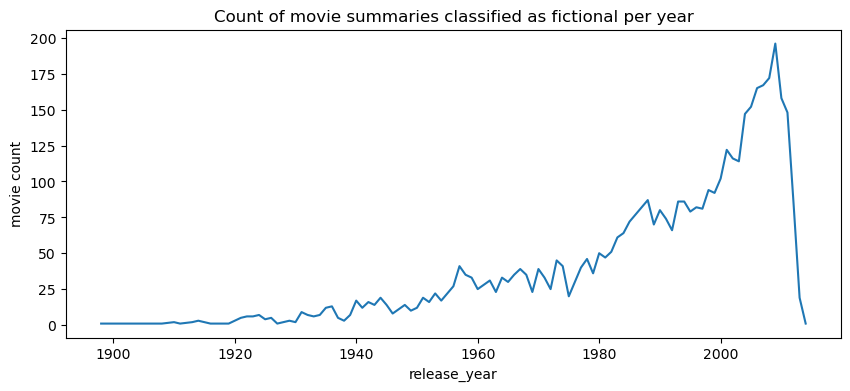

In [15]:
plt.figure(figsize=(10,4))
sns.lineplot(df_fictional_summaries_all.groupby('release_year')['Wikipedia_movie_ID'].agg("count"))
plt.ylabel('movie count')
plt.title('Count of movie summaries classified as fictional per year')

# Preprocessing the summaries for topic modelling
Preprocessing the summaries involves, via tokenization, removing stop words and proper noun and taking only the lemma of each word.

In [16]:
from tqdm import tqdm

# natural language processing
import spacy

# topic modelling and preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation

#nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_md")

In [17]:
nlp = spacy.load("en_core_web_md")

def preprocess_docs(docs, nlp=nlp, batch_size=100, n_process=-1, entities_to_include = ['EVENT', 'DATE', 'LOC']):
    result_array = []
    for doc in tqdm(nlp.pipe(docs, disable=["parser", "textcat"], batch_size=batch_size, n_process=n_process)):
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ not in ['PROPN']]
        for ent in doc.ents:
            if ent.label_ in entities_to_include:
                element = ent.text.lower()
                for token in ent:
                    if (token not in tokens) and (not token.is_stop):
                        tokens.append(token.lemma_)

        result_array.append(" ".join(tokens))
    return result_array

In [18]:
# Apply the preprocessing algorithms on each movie summary
docs = df_fictional_summaries_all['movie_summary']
df_fictional_summaries_all['preprocessed_summary'] = preprocess_docs(docs, batch_size=128) # takes around 3min

df_fictional_summaries_all.head() 

4701it [02:39, 29.48it/s] 


,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_genres,release_year,period,preprocessed_summary
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012.0,after 2010s,nation consist wealthy poor district punishmen...
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,"{""/m/08322"": ""Wuxia"", ""/m/0hj3n2k"": ""Fantasy A...",1998.0,90s,evil head give prophecy say find young child g...
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,"{""/m/0219x_"": ""Indie"", ""/m/0424mc"": ""Experimen...",2003.0,2000-2005,great depression old fortune teller predict fu...
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,"{""/m/09q17"": ""Slapstick"", ""/m/0hj3n2s"": ""Fanta...",1997.0,90s,career focus lawyer divorced father love spend...
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,"{""/m/02n4kr"": ""Mystery"", ""/m/02l7c8"": ""Romance...",1946.0,before 1950,winter immediately liberation member french un...


In [19]:
#Preprocessing lead to some empty summaries
df_nan= df_fictional_summaries_all["preprocessed_summary"].isna()
df_empty = (df_fictional_summaries_all['preprocessed_summary'] == '')
df_fictional_summaries_all[df_nan | df_empty]

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_genres,release_year,period,preprocessed_summary
509,22646837,* Johnny Yong Bosch: Jack Ellis/Hiroki * Dani...,Broken Path,NaN,NaN,90.0,"{""/m/04t2t"": ""Martial Arts Film""}",NaN,NaN,


In [20]:
# Empty preprocessed summaries removal
df_fictional_summaries_all = df_fictional_summaries_all.drop(df_fictional_summaries_all[df_nan | df_empty].index)
df_fictional_summaries_all.shape #(10867, 8)

(4699, 10)

In [21]:
# We can then analysze the number of features (words after preprocessing) for each 
vectorizer5 = CountVectorizer(min_df=5, binary=True)
dtm5 = vectorizer5.fit_transform(df_fictional_summaries_all['preprocessed_summary'])
df_fictional_summaries_all['wordcount_min5freq'] = np.sum(dtm5, axis = 1) #number of word in the preprocessed summaries for each movie
dtm5.shape #(10867, 12600)

(4699, 9193)

C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

Text(0.5, 1.0, 'Average number of words in preprocessed summaries over time')

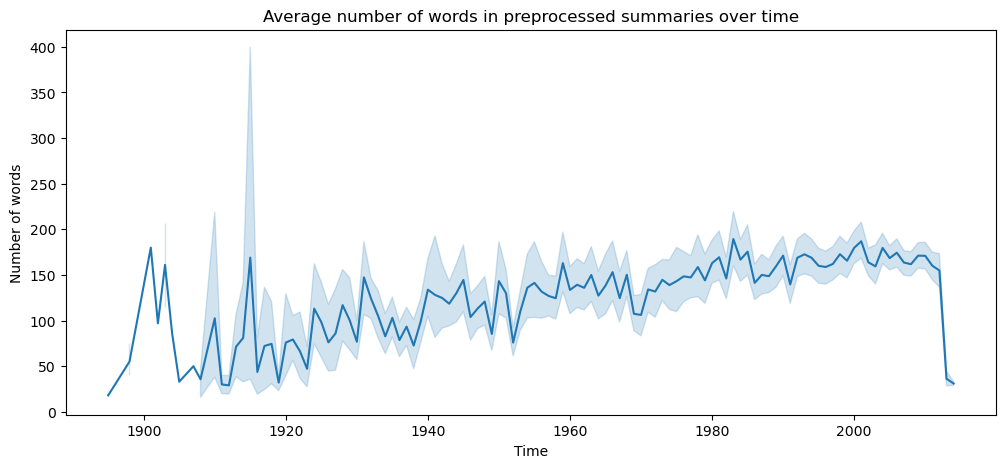

In [30]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_fictional_summaries_all.reset_index() , x = 'release_year', y = 'wordcount_min5freq')
plt.ylabel('Number of words')
plt.xlabel('Time')
plt.title('Average number of words in preprocessed summaries over time')            

After 1950, the mean number of words in the preprocessed summaries is more stable with a slight increase and variation of around 30 words. 
This is a good news because it means that if by performing a topic modelling on each decades after 1950, the results wont be biaised by the number of words per summaries. 

Text(0.5, 0, 'summary count')

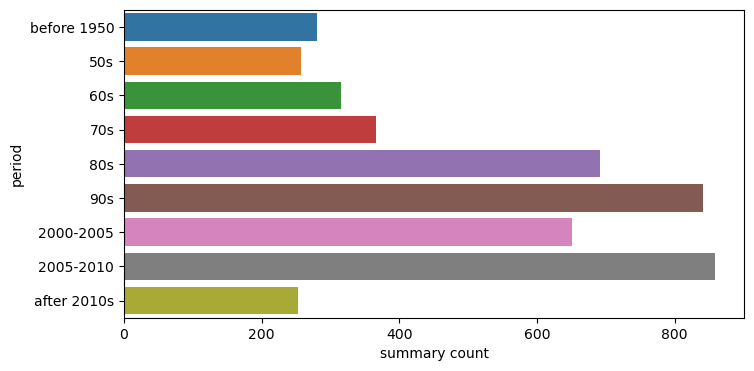

In [23]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_fictional_summaries_all, y='period')
plt.xlabel('summary count')

Text(0.5, 0, 'number of feature (tokens) per summary')

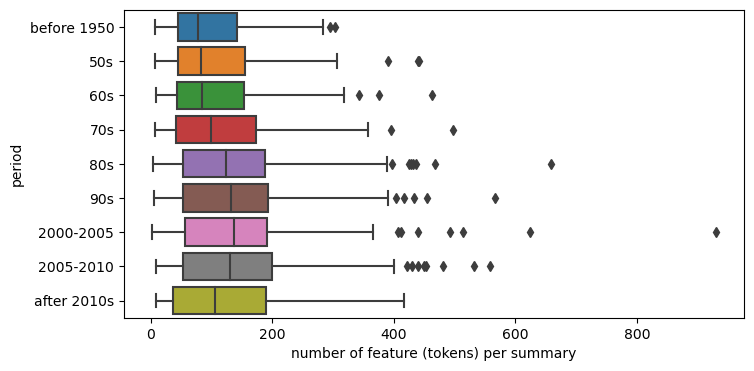

In [24]:
# plot token counts
plt.figure(figsize=(8,4))
sns.boxplot(data = df_fictional_summaries_all, x = 'wordcount_min5freq', orient='h', y = 'period')
plt.xlabel('number of feature (tokens) per summary')

In [25]:
#vectorizer5 = CountVectorizer(min_df=5, max_features=8000)
#dtm5 = vectorizer5.fit_transform(df_fictional_summaries_all['preprocessed_summary'])
#df_fictional_summaries_all['wordcount_min5freq_n8000'] = np.count_nonzero(dtm5.toarray(), axis = 1) #number of word in the preprocessed summaries for each movie
# plot token counts
#plt.figure(figsize=(8,4))
#sns.boxplot(data = df_fictional_summaries_all, x = 'wordcount_min5freq_n8000', orient='h', y = 'period')
#plt.xlabel('feature (tokens) count per summary')

In [64]:
display(df_fictional_summaries_all)

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_genres,release_year,preprocessed_summary,wordcount_min5freq,period,wordcount_min5freq_n8000
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012.0,nation consist wealthy poor district punishmen...,232,after 2010s,231
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,"{""/m/08322"": ""Wuxia"", ""/m/0hj3n2k"": ""Fantasy A...",1998.0,evil head give prophecy say find young child g...,92,90s,89
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,"{""/m/0219x_"": ""Indie"", ""/m/0424mc"": ""Experimen...",2003.0,great depression old fortune teller predict fu...,183,2000-2005,176
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,"{""/m/09q17"": ""Slapstick"", ""/m/0hj3n2s"": ""Fanta...",1997.0,career focus lawyer divorced father love spend...,183,90s,180
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,"{""/m/02n4kr"": ""Mystery"", ""/m/02l7c8"": ""Romance...",1946.0,winter immediately liberation member french un...,46,before 1950,44
...,...,...,...,...,...,...,...,...,...,...,...,...
755,8235569,Good and Evil are two sides of a same coin. If...,Rudraksh,2004-02-13,NaN,144.0,"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",2004.0,good side coin good grow strength evil come po...,172,2000-2005,170
756,183550,"Between visits from his keeper, or john, a han...",Pink Narcissus,1971,NaN,71.0,"{""/m/0hn10"": ""LGBT"", ""/m/02nxfrh"": ""Adult"", ""/...",1971.0,visit keeper handsome male prostitute apartmen...,22,70s,22
757,4703636,"While in Wales visiting her husband James , Ad...",The Dark,2005-05,NaN,93.0,"{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2005.0,visit husband try fix relationship daughter cl...,121,2000-2005,119
758,20642521,Eduard Zuiderwijk runs a restaurant in Africa...,White Light,2008-12-11,NaN,92.0,"{""/m/07s9rl0"": ""Drama""}",2008.0,run restaurant wife suddenly die leave care so...,23,2005-2010,23


## i) optional supp:  read/saving dataframe

In [136]:
file = os.path.abspath('output_data/df_summaries_preprocessed_all.csv')
task = 'read' # 'read', 'save

if task =='save':
    df_fictional_summaries_all.to_csv(file)
    print(f'saved df to {file}')
    
elif task=='read':
    df_fictional_summaries_all = pd.read_csv(file)
    print(f"Loaded dataframe from {file}")

    df_fictional_summaries_all['period'] = pd.cut(df_fictional_summaries_all.release_year,
                                              bins=[0, 1950, 1960, 1970, 1980, 1990, 2000, 2005, 2010, 2023],
                                              labels=['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', 'after 2010s'])

Loaded dataframe from c:\Users\gezas\kDrive\ADA\Project\output_data\df_summaries_preprocessed_all.csv


## ii) LDA topic modelling overall

In [76]:
from topic_modeling import plot_top_words

In [77]:
def topic_modelling(subset, n_features=None, binary_count = True,
                    n_topics = 10, alpha = 0.2, eta = 0.05,
                    max_iter = 50, random_seed = 7, n_top_words=10, norm = False, idf = False, sublinear_tf = False):
    
    if norm:
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2), max_features=n_features, use_idf=False, norm='l1', sublinear_tf=sublinear_tf)
    elif idf:
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2), max_features=n_features, use_idf=True, norm='l1',  sublinear_tf=sublinear_tf)
    else:
        vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2), max_features=n_features, binary=binary_count)
        
    dtm = vectorizer.fit_transform(subset['preprocessed_summary'])
    print(f'Shape of the feature matrix is {dtm.shape}')

    # Create the LatentDirichletAllocation model
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        doc_topic_prior= alpha, 
        topic_word_prior= eta,
        max_iter=max_iter,
        random_state=random_seed,
        verbose=0,
        learning_method='batch',
        n_jobs = -1
    )

    lda.fit(dtm)
    #lda.fit(dtm_normalized)
    return lda, vectorizer

def get_top_words_weights(lda_model, vectorizer, n=10):
    """
    Save the top n words and their weights for each topic in a CSV file.

    Parameters:
    - lda_model: The trained LDA model.
    - vectorizer: The vectorizer used for data transformation.
    - n: The number of top words to save for each topic.
    - filename: The name of the CSV file to save the results.

    Returns:
    None
    """
    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Create a MultiIndex for the DataFrame columns
    columns = pd.MultiIndex.from_product([['Word', 'Weight'], range(0, len(lda_model.components_))], names=[None, 'Rank'])

    # Create a DataFrame to store the results
    top_words_df = pd.DataFrame(index=range(n), columns=columns)
    # Iterate through each topic in the LDA model
    for topic_idx, topic in enumerate(lda_model.components_):
        # Get the indices of the top n words for the current topic
        top_features_ind = topic.argsort()[-n:][::-1]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        # Assign the values to the DataFrame
        top_words_df.loc[:,('Word', topic_idx)] = top_features
        top_words_df.loc[:,('Weight', topic_idx)] = weights

    return top_words_df


def plot_topwords_heatmap(lda = None, vectorizer=None, df_word_ranks=None, n_top_words = 10, title = None, save_to_filename = None ):
    '''Plots the top n words as '''
    if df_word_ranks is None:
        if lda is None | vectorizer is None:
            raise(ValueError("Either lda and vectorizer should be given, or directly word and weight dataframe."))
        df_word_ranks = get_top_words_weights(lda ,vectorizer, n=n_top_words)
    else:
        if df_word_ranks.shape[0]!=n_top_words:
            n_top_words = df_word_ranks.shape[0]
    
    # Create a heatmap
    plt.figure(figsize=(15, 5))
    sns.heatmap(df_word_ranks['Weight'].T.astype(float), cmap='YlGnBu', annot=df_word_ranks['Word'].T, fmt="", linewidths=.5)
    
    # Customize the plot
    if title is None:
        plt.title(f'Top {n_top_words} Words for Each Topic')
    else:
        plt.title(title)

    plt.xlabel('Word Rank')
    plt.ylabel('Topics')

    if save_to_filename:
        print(f"saving figure to {save_to_filename}")
        plt.savefig(save_to_filename)
    
    plt.show()
    return

In [27]:
#docs = df_fictional_summaries_all[df_fictional_summaries_all.period=='before 1950']['preprocessed_summary']
docs = df_fictional_summaries_all['preprocessed_summary']

# Some parameter to fit
n_features = None

# Vectorize the summaries

# binary bag of words (good results)
vectorizer = CountVectorizer(stop_words='english', max_df = 0.5, min_df=10, ngram_range=(1,2), max_features=n_features, binary=True)

# row normalized bag of words (good results when overall)
vectorizer_norm = TfidfVectorizer(stop_words='english', max_df = 0.5, min_df=10, use_idf=False, ngram_range=(1,2), norm='l1')

dtm = vectorizer.fit_transform(docs)

# normalize matrix per row (not necessary since can use tfidf with use_idf = False)
#transformer = Normalizer(norm='l1').fit(dtm)
#dtm = transformer.transform(dtm)

dtm_norm = vectorizer_norm.fit_transform(docs)

tf_feature_names = vectorizer.get_feature_names_out()

dtm.shape, dtm_norm.shape # ((10867, X), (10867, X))

((4699, 10083), (4699, 10083))

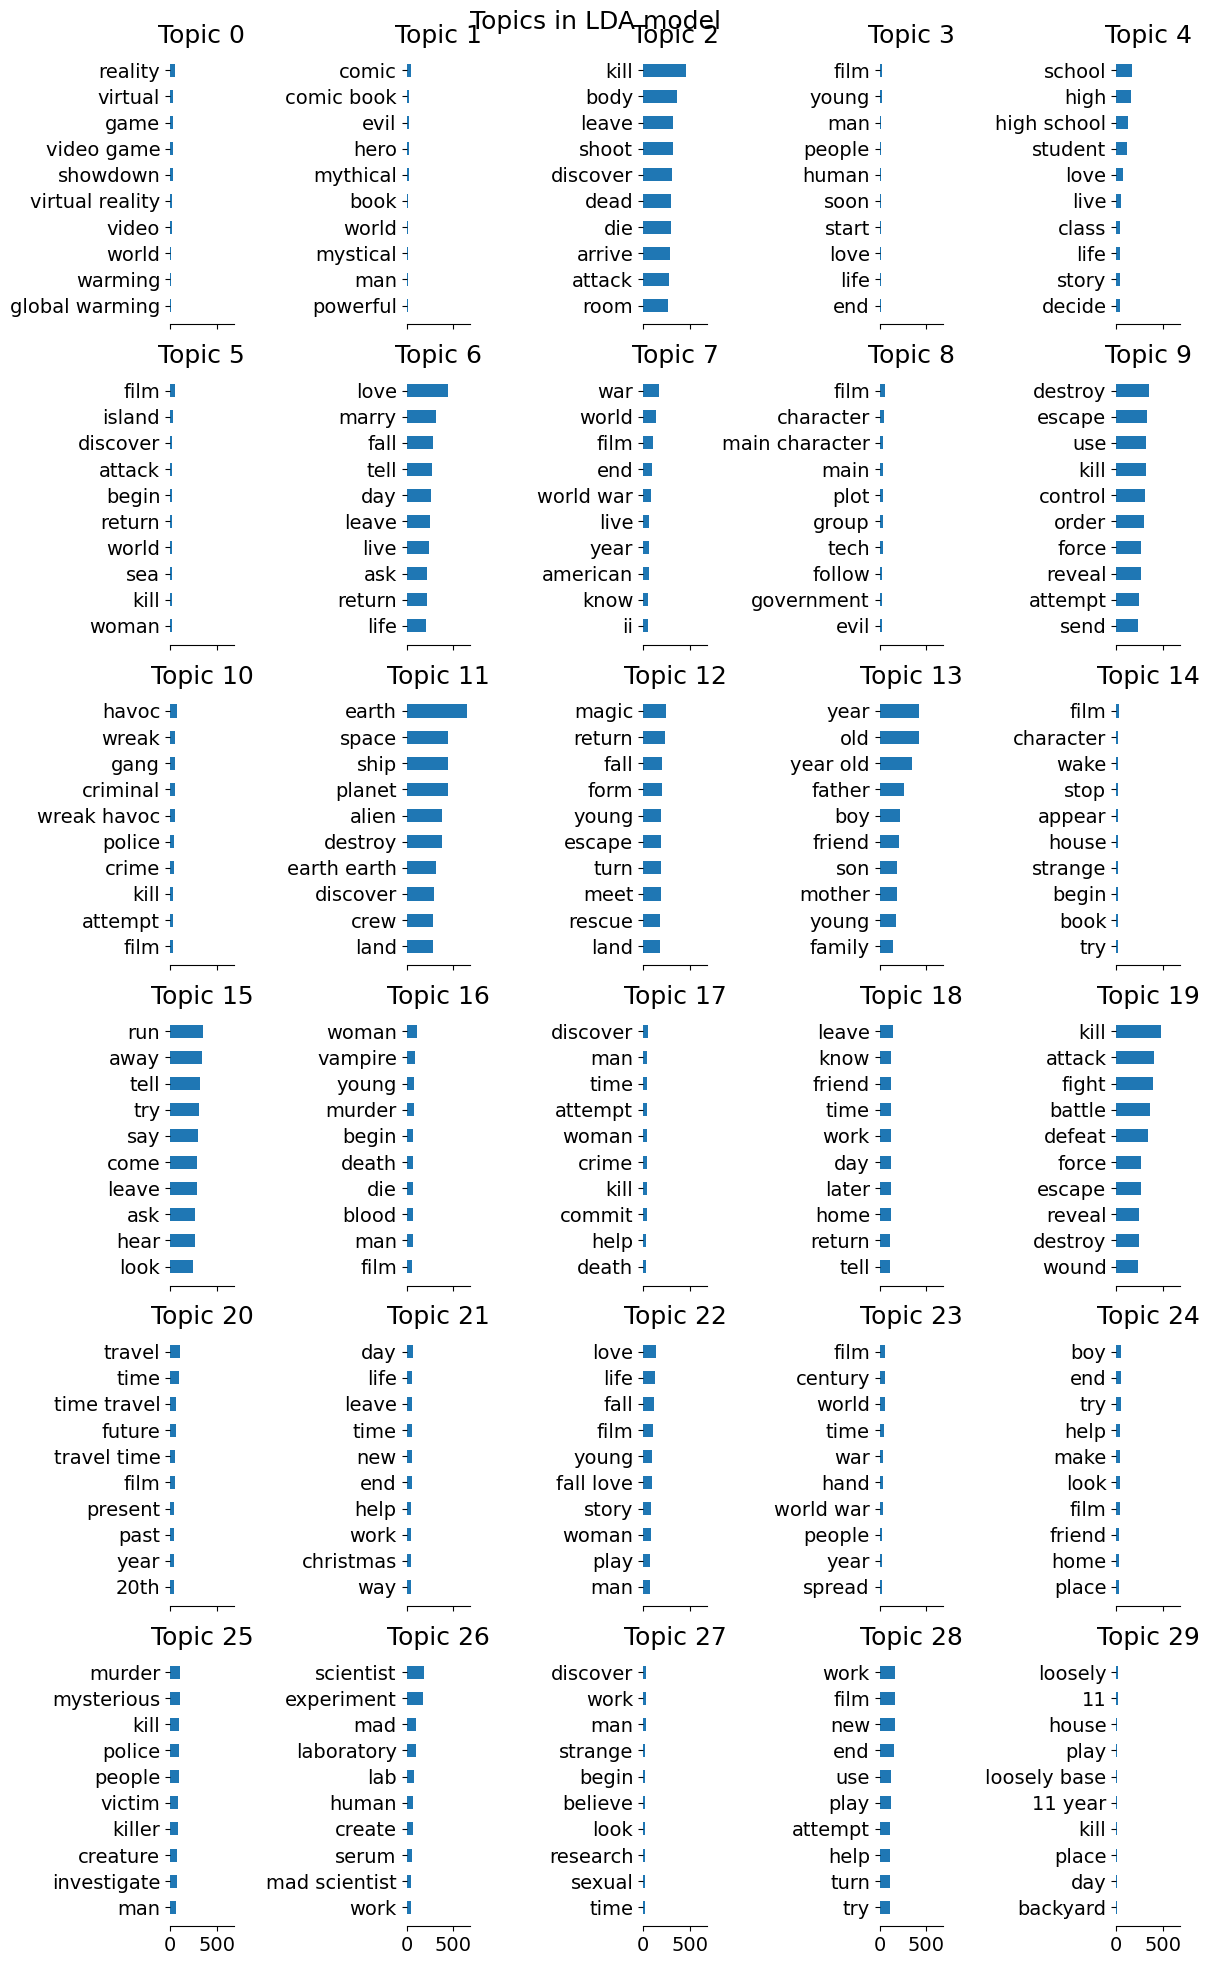

In [51]:
# General parameters to adapt
n_topics = 30
n_top_words = 10
alpha = 0.15
# doc_topic_prior:=alpha : represents the parameter of the Dirichlet prior on the per-document topic distributions. It influences how many topics are likely to be present in a document.
    # Higher alpha values result in documents with more topics, while lower values lead to sparser documents with fewer dominant topics.
beta = 0.05
# topic_word_prior := beta : represents the parameter of the Dirichlet prior on the per-topic word distributions. It controls the number of words associated with each topic.
#Similar to alpha, higher beta values result in topics with more words, while lower values lead to sparser topics.

random_state=7

# Create the LatentDirichletAllocation model
lda = LatentDirichletAllocation(n_components=n_topics,
                                doc_topic_prior= alpha,
                                topic_word_prior= beta,
                                learning_method='batch',
                                max_iter=100,
                                random_state=random_state, n_jobs=-1, verbose=0)

lda.fit(dtm)
#lda.fit(dtm_norm)

# Plot the top n words for all topics
#topics_dict = plot_top_words(lda, vectorizer_norm.get_feature_names_out(), n_top_words=10, n_topics=n_topics, title="Topics in LDA model")
topics_dict = plot_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, n_topics=n_topics, title="Topics in LDA model")

In [52]:
# Get and save the top n words for all topics
topics_overall_df = get_top_words_weights(lda_model=lda, vectorizer=vectorizer, n=20)
topics_overall_df.to_csv('output_data/lda_top_words_overall.csv')

<Axes: >

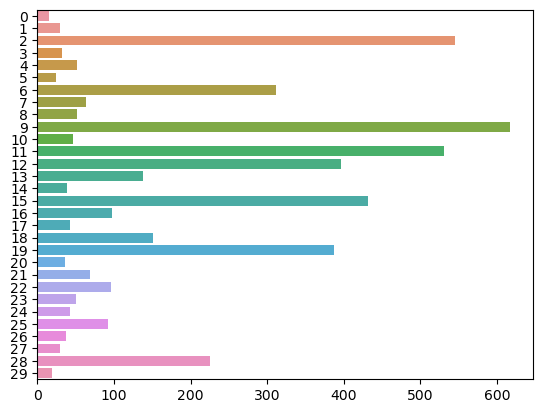

In [53]:
# dtm=doc_topic_matrix is the matrix of document-topic probabilities obtained from lda.transform()

# Identify dominant topics for each summary and count per topic
dominant_topics = np.argmax(lda.transform(dtm), axis=1)

unique, counts = np.unique(dominant_topics, return_counts=True)

sns.barplot(x=counts, y = unique, orient='h')

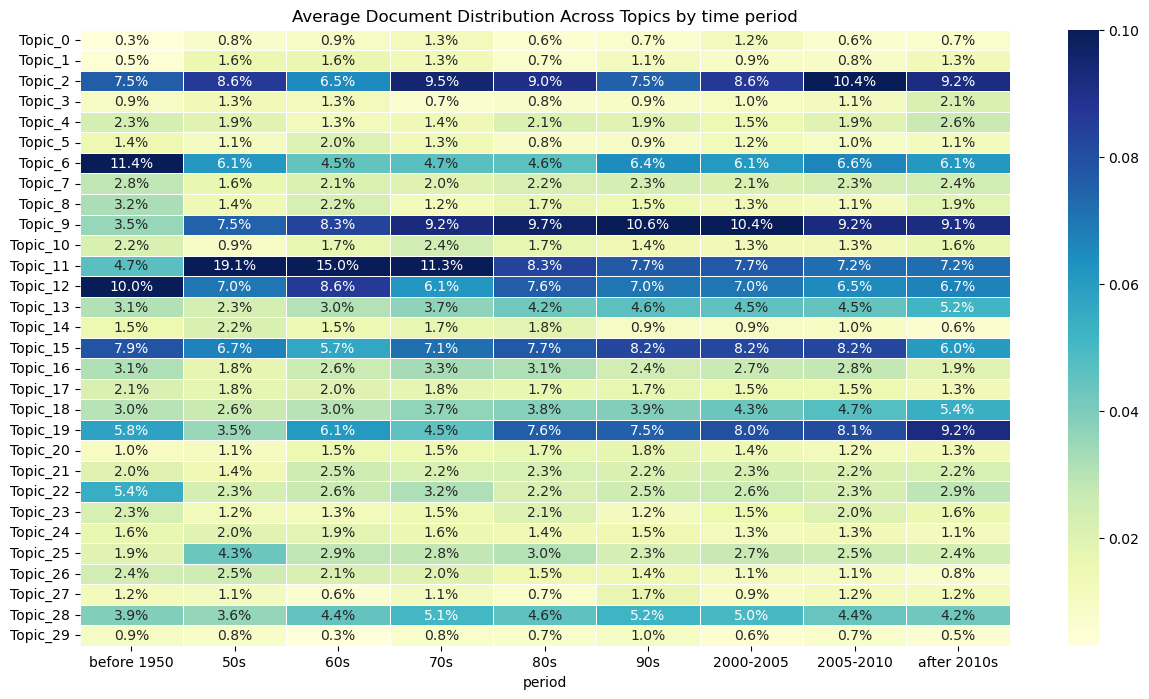

In [54]:
# Transform documents into the topic probability space
doc_topic_probas = lda.transform(dtm)

# Create a DataFrame with the document-topic matrix
df_doc_topic = pd.DataFrame(doc_topic_probas, columns=[f'Topic_{i}' for i in range(lda.n_components)])

# Add information on the time period
df_doc_topic['period'] = df_fictional_summaries_all['period'].to_list()

# Group by decade and calculate the average topic probabilities
df_decade_avg = df_doc_topic.groupby('period').mean()

df_decade_avg.to_csv("output_data/topic_distrib_decade_avg.csv")

period_order = ['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', 'after 2010s']
# Plot a heatmap to visualize the document distribution across topics for each decade
plt.figure(figsize=(15, 8))
sns.heatmap(df_decade_avg.transpose()[period_order], cmap='YlGnBu', annot=True, fmt=".1%", linewidths=.5, vmax=0.1)
plt.title('Average Document Distribution Across Topics by time period')
plt.show()

## iii) Topics over Time

In [55]:
for period, subset in df_fictional_summaries_all.groupby('period'):
    # Perform analysis on each subset
    print(f"Analyzing data for period: {period}")
    
    vectorizer = CountVectorizer(max_df=0.5, min_df=10, ngram_range = (1,2))
    #vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features, ngram_range=(1, 2), norm='l1')

    dtm = vectorizer.fit_transform(subset['preprocessed_summary'])
    print(dtm.shape)

Analyzing data for period: before 1950
(281, 650)
Analyzing data for period: 50s
(257, 659)
Analyzing data for period: 60s
(315, 812)
Analyzing data for period: 70s
(366, 999)
Analyzing data for period: 80s
(691, 2035)
Analyzing data for period: 90s
(842, 2418)
Analyzing data for period: 2000-2005
(651, 2004)
Analyzing data for period: 2005-2010
(858, 2537)
Analyzing data for period: after 2010s
(253, 714)


> we search for the topics of sci fiction with the hypothesis that 15 topics is a good estimate which could include also some less important topics in term of word appearance.
> Each movies would tipycally be represented by around 3 topics (for example war, spaceships, love). this could be parametrized 

### 1) before 50s

In [96]:
# get subset of summaries before 1950
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='before 1950']
# LDA topic modelling of the subset
lda_b50s, vectorizer_b50s = topic_modelling(subset, n_topics=15, alpha=0.1, eta = 0.01, max_iter = 100, random_seed=11)

Shape of the feature matrix is (281, 630)


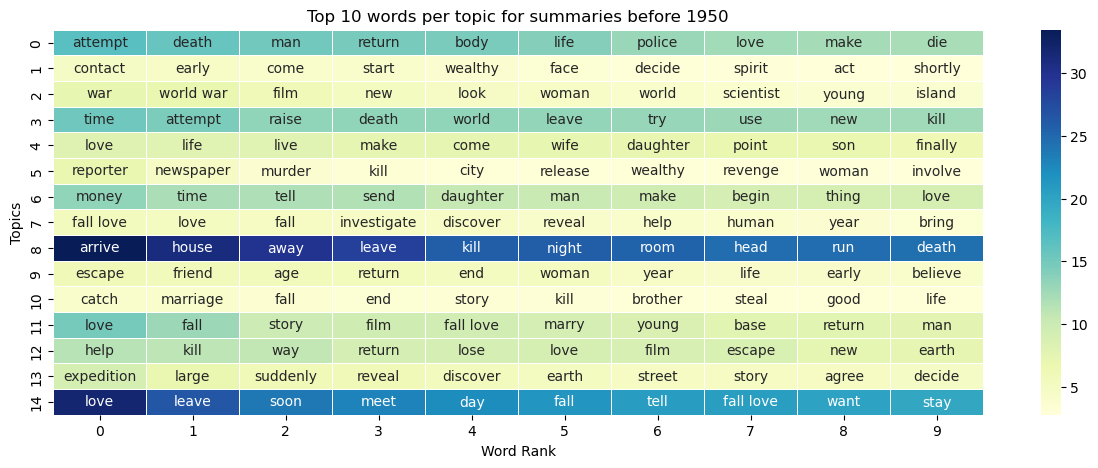

In [97]:
# Get the top10 words of each topic and their weight
df_top10words_b50s = get_top_words_weights(lda_b50s, vectorizer_b50s, n=10)
df_top10words_b50s.to_csv("output_data/df_top10words_b50s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_b50s, title='Top 10 words per topic for summaries before 1950')

### 2) 50s

In [99]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='50s']
lda_50s, vectorizer_50s = topic_modelling(subset, n_topics=15, alpha=0.1, eta = 0.05, random_seed=5)

Shape of the feature matrix is (257, 643)


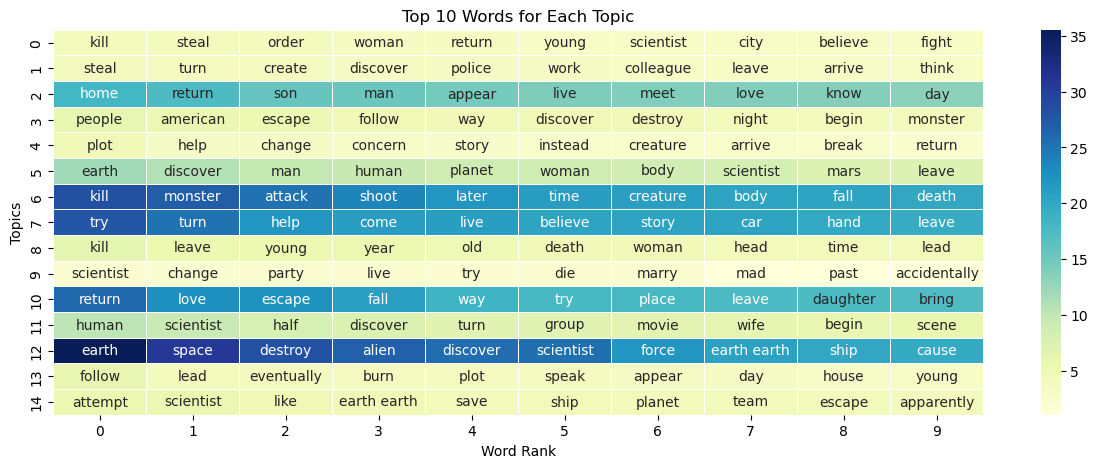

In [100]:
# Get the top10 words of each topic and their weight
df_top10words_50s = get_top_words_weights(lda_50s, vectorizer_50s, n=10)
df_top10words_50s.to_csv("output_data/df_top10words_50s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_50s)

### 3) 60s

In [109]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='60s']
lda_60s, vectorizer_60s = topic_modelling(subset, n_topics=15, alpha=0.1, eta = 0.01, max_iter=100, random_seed=11)
# less movies so adjust alpha to have fewer "topics" per summary

Shape of the feature matrix is (315, 793)


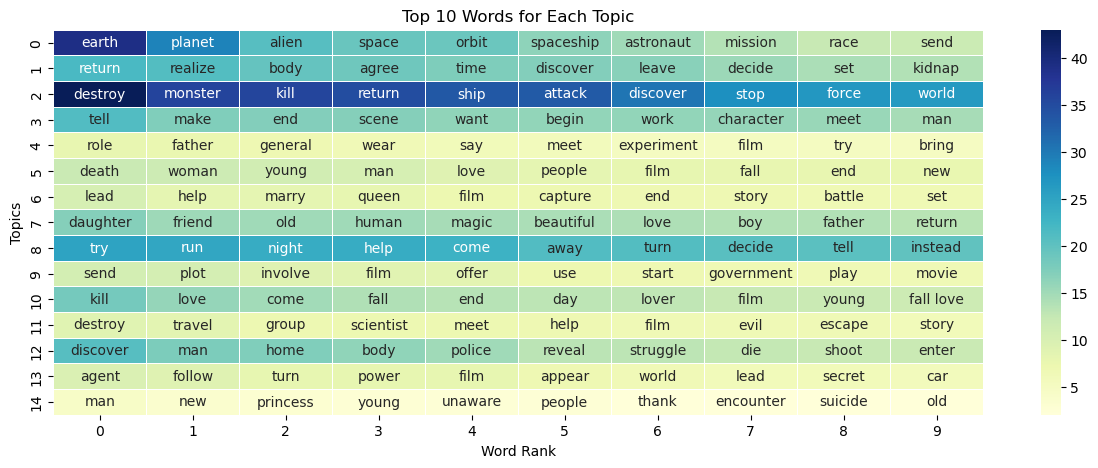

In [110]:
# Get the top10 words of each topic and their weight
df_top10words_60s = get_top_words_weights(lda_60s, vectorizer_60s, n=10)
df_top10words_60s.to_csv("output_data/df_top10words_60s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_60s)

### 4) 70s

In [120]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='70s']
lda_70s, vectorizer_70s = topic_modelling(subset, n_features=None, n_topics=15, alpha=0.1, eta = 0.05, random_seed=11, max_iter=100, binary_count=True)

Shape of the feature matrix is (366, 976)


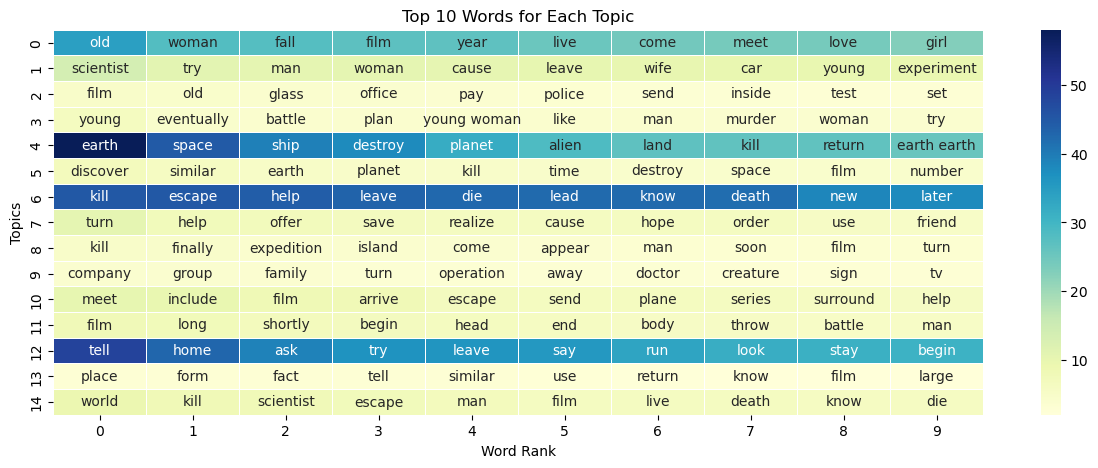

In [121]:
# Get the top10 words of each topic and their weight
df_top10words_70s = get_top_words_weights(lda_70s, vectorizer_70s, n=10)
df_top10words_70s.to_csv("output_data/df_top10words_70s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_70s)

### 5) 80s

In [132]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='80s']
lda_80s, vectorizer_80s = topic_modelling(subset, n_features=None, n_topics=15, alpha=0.15, eta = 0.05, random_seed=11, max_iter=50, binary_count=True)

Shape of the feature matrix is (691, 1989)


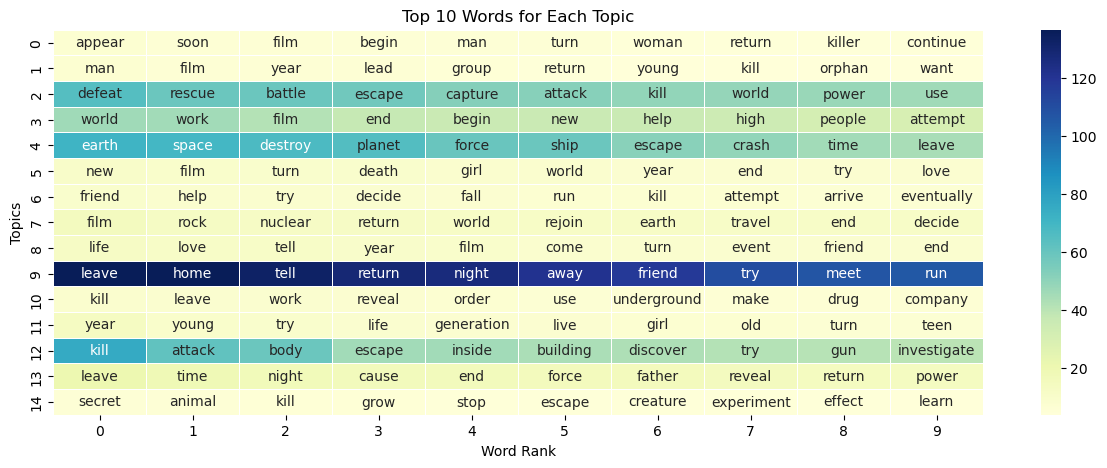

In [133]:
# Get the top10 words of each topic and their weight
df_top10words_80s = get_top_words_weights(lda_80s, vectorizer_80s, n=10)
df_top10words_80s.to_csv("output_data/df_top10words_80s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_80s)

### 6) 90s

In [155]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='90s']
lda_90s, vectorizer_90s = topic_modelling(subset, n_features=None, n_topics=15, alpha=0.2, eta = 0.05, random_seed=5, max_iter=100, binary_count=True)

Shape of the feature matrix is (842, 2364)


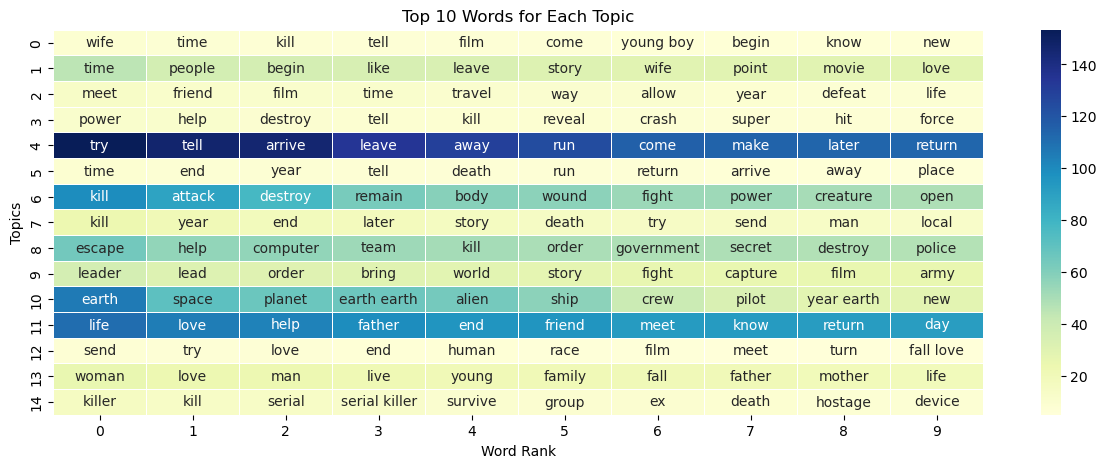

In [156]:
# Get the top10 words of each topic and their weight
df_top10words_90s = get_top_words_weights(lda_90s, vectorizer_90s, n=10)
df_top10words_90s.to_csv("output_data/df_top10words_90s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_90s)

### 7) 2000-2005

In [165]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='2000-2005']
lda_00_05, vectorizer_00_05 = topic_modelling(subset, n_features=None, n_topics=15, alpha=0.1, eta = 0.01, random_seed=7, max_iter=100, binary_count=True)

Shape of the feature matrix is (651, 1952)


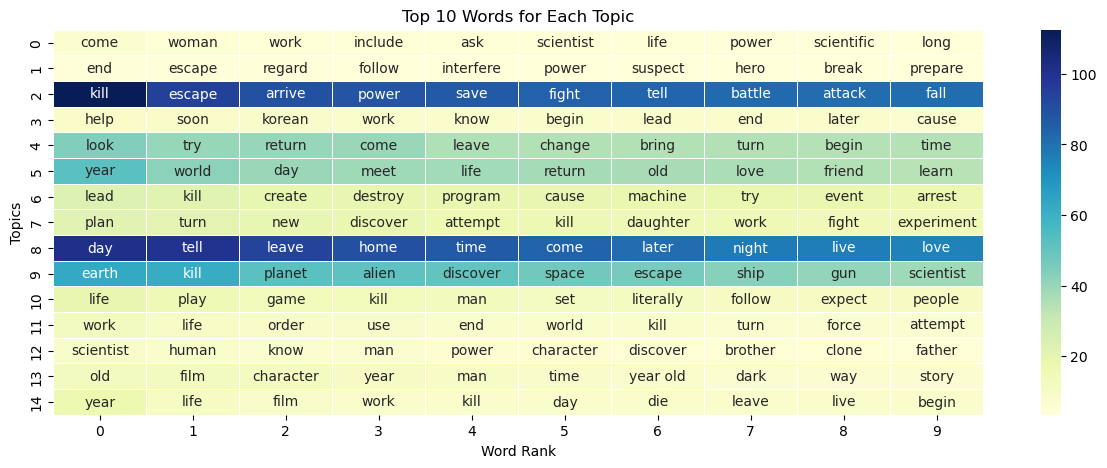

In [166]:
# Get the top10 words of each topic and their weight
df_top10words_00_05 = get_top_words_weights(lda_00_05, vectorizer_00_05, n=10)
df_top10words_00_05.to_csv("output_data/df_top10words_00_05.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_00_05)

we observe already how governement and scientis topic becomes more present (and stable to random). World War dissappears.

### 8) 2005-2010

In [179]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='2005-2010']
lda_05_10, vectorizer_05_10 = topic_modelling(subset, n_features=None, n_topics=15, alpha=0.1, eta = 0.01, random_seed=11, max_iter=100, binary_count=True)

Shape of the feature matrix is (858, 2474)


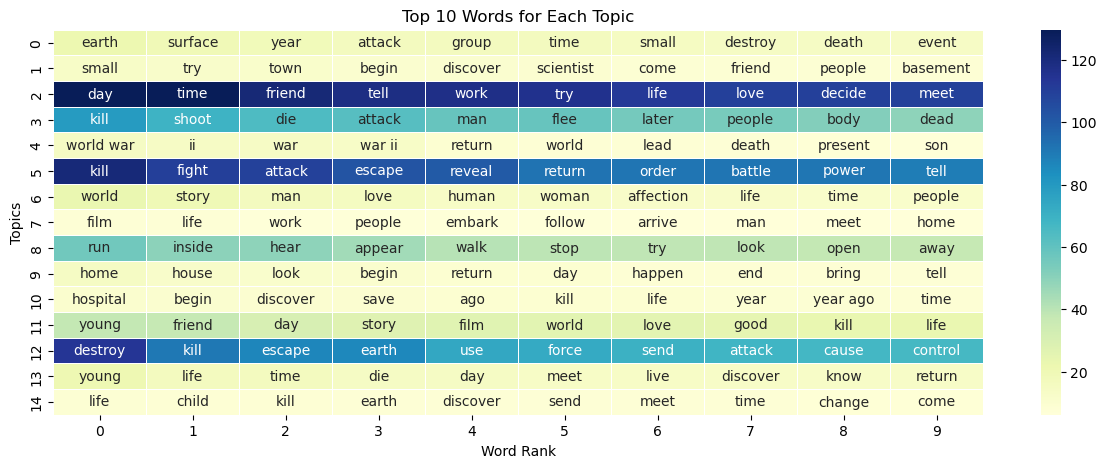

In [180]:
# Get the top10 words of each topic and their weight
df_top10words_05_10 = get_top_words_weights(lda_05_10, vectorizer_05_10, n=10)
df_top10words_05_10.to_csv("output_data/df_top10words_05_10.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_05_10)

### 9) 10s

In [184]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='after 2010s']
lda_10s, vectorizer_10s = topic_modelling(subset, n_features=1500, n_topics=15, alpha=0.1, eta = 0.01, random_seed=7, max_iter=100, binary_count=True)

Shape of the feature matrix is (253, 696)


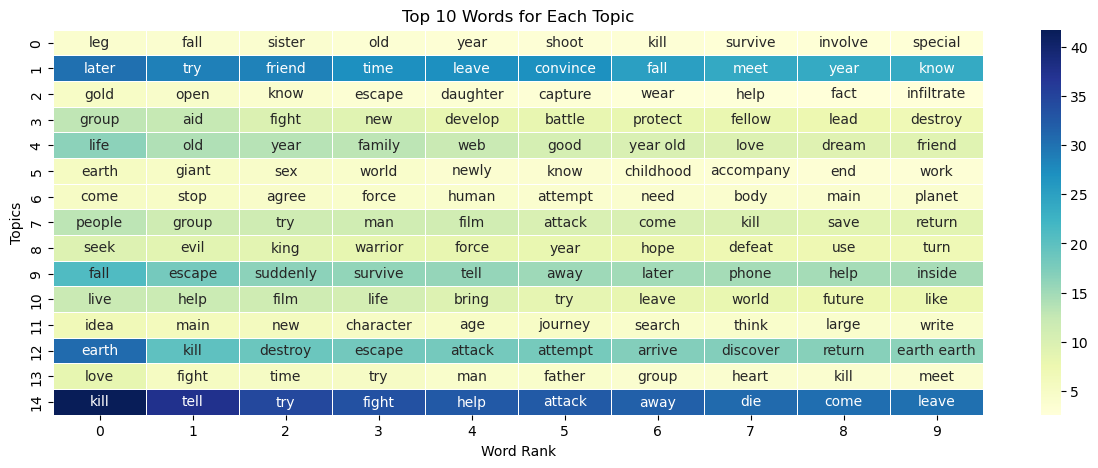

In [185]:
# Get the top10 words of each topic and their weight
df_top10words_10s = get_top_words_weights(lda_10s, vectorizer_10s, n=10)
df_top10words_05_10.to_csv("output_data/df_top10words_10s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_10s)

# Search for specific topics over time

In [129]:
specified_topics = {'outer_space_related' : [ "alien", "ufo", "extraterrestrial",
                                              "space", "spaceship", "outerspace"],
                    'science_related' : [ "scientist", "science", "researcher", "research",
                                          "experiment", "experimentation", "laboratory"],
                    'government_related' : [ "government", "society", "politics", "regime",
                                             "council"],
                    'creatures_related' : ['creatures', 'monsters', 'vampires'],
                    'robots_related' : ['robot', 'droid', 'cyborg'],
                    'digital_related' : ['computer', 'artificial intelligence', 'cyber', 'virtual reality',
                                        'cyberspace', 'programmer', 'hacking', 'digital'],
                    'magic_related': ['magic', 'sorcerer', 'wizard', 'witchcraft', 'spell', 'enchantment', 
                                      'sorcery', 'witch', 'mage', 'mystical'],

                    'war_related': ['war', 'battle', 'conflict', 'combat', 'military',
                                     'army', 'warfare', 'soldier'],

                    'time_travel_related' : [ "time travel", "travel time", "temporal displacement",
                                                "time dilation", "time machine", "temporal journey",
                                                "time loop", "time manipulation", "temporal paradox",
                                                "time warp"], 

                    'apocalypse_related' : ['apocalypse', 'doomsday', 'end world', 'world end', 'armageddon', 'post-apocalyptic',
                                            'apocalyptic', 'cataclysm', 'world destruction', 'human extinction', 'mass extinction',
                                            'end of civilization']
 }

def contains_any_word(df, word_list):
    # Check if any of the words in word_list is present in summaries (raw)
    mask_summary = df['movie_summary'].str.contains('|'.join(word_list), case=False)
    # Check if any of the words in word_list is present in preprocessed summary (advantage of lemmatization)
    mask_preprocessed_summary = df['preprocessed_summary'].str.contains('|'.join(word_list), case=False)
    # Combine the masks (logical OR)
    full_mask = mask_summary | mask_preprocessed_summary
    
    return full_mask

In [138]:
# Go through all specified topics and for each summary in datframe check if it contains a word related to this topic
df_specified_topics = df_fictional_summaries_all[['Wikipedia_movie_ID', 'release_year', 'period', 'movie_summary', 'preprocessed_summary']].copy()
for specific_topic in specified_topics.keys():
    df_specified_topics[specific_topic] = contains_any_word(df=df_specified_topics, word_list=specified_topics[specific_topic])

display(df_specified_topics.head())

,Wikipedia_movie_ID,release_year,period,movie_summary,preprocessed_summary,outer_space_related,science_related,government_related,creatures_related,robots_related,digital_related,magic_related,war_related,time_travel_related,apocalypse_related
0,31186339,2012.0,after 2010s,The nation of Panem consists of a wealthy Capi...,nation consist wealthy poor district punishmen...,False,False,False,True,False,False,False,True,False,False
1,1838882,1998.0,90s,"The evil Lord Conqueror, head of Conqueror's C...",evil head give prophecy say find young child g...,False,False,False,False,False,False,False,True,False,False
2,4466226,2003.0,2000-2005,During the Great depression in 1933 in Winnipe...,great depression old fortune teller predict fu...,False,False,False,False,False,False,False,False,False,False
3,657446,1997.0,90s,"In Los Angeles, California Fletcher Reede is ...",career focus lawyer divorced father love spend...,False,True,False,False,False,False,False,False,False,False
4,32163620,1946.0,before 1950,"In the winter of 1945, immediately after the l...",winter immediately liberation member french un...,False,False,False,False,False,False,False,True,False,False


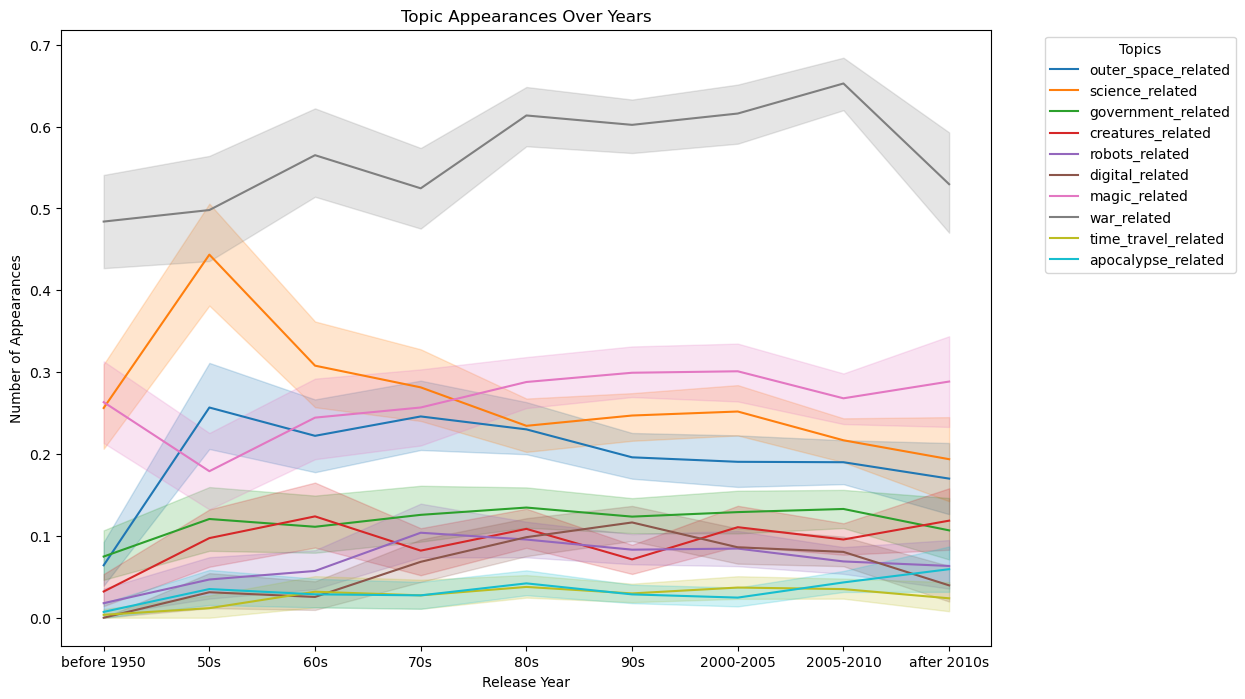

In [139]:
# Drop unnecessary columns
df_topic_appearance = df_specified_topics.drop(['Wikipedia_movie_ID', 'movie_summary', 'preprocessed_summary'], axis=1)

# Melt the DataFrame to make it suitable for plotting
melted_df = pd.melt(df_topic_appearance, id_vars=['period', 'release_year'], value_vars=df_topic_appearance.keys(), var_name='Topic', value_name='Appearance')

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='period', y='Appearance', hue='Topic', data=melted_df)
plt.title('Topic Appearances Over Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Appearances')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

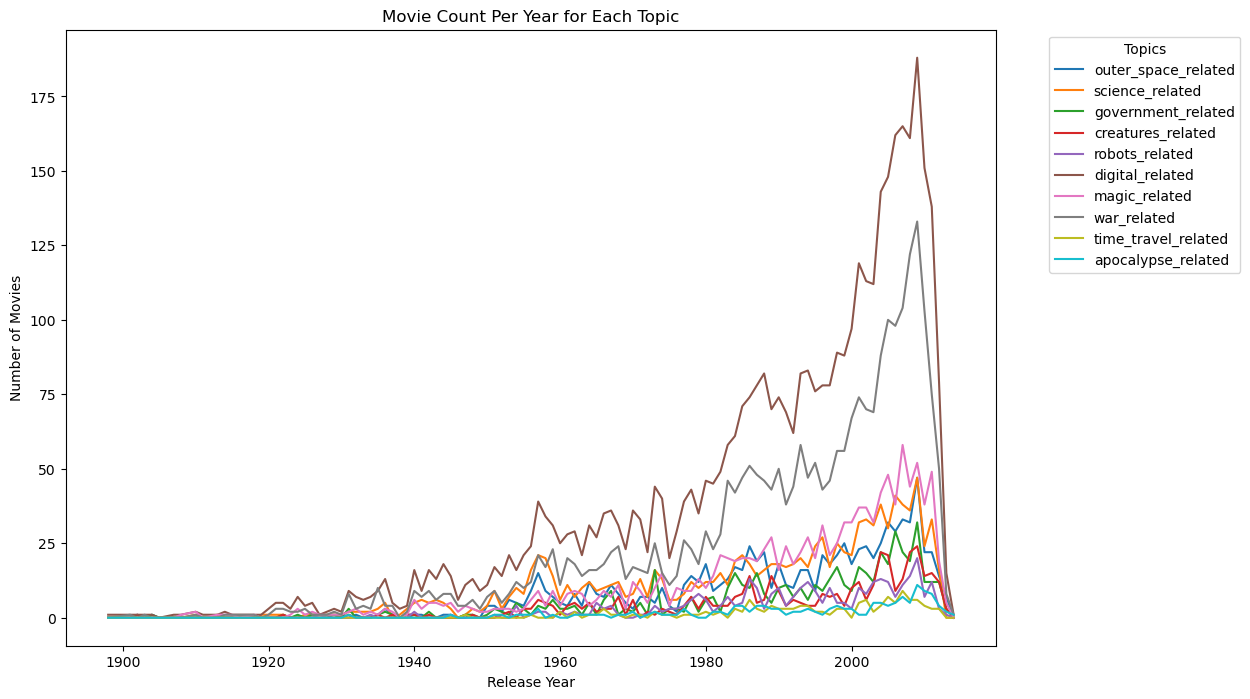

In [116]:
# Drop unnecessary columns
df_topic_appearance = df_specified_topics.drop(['Wikipedia_movie_ID', 'movie_summary', 'preprocessed_summary'], axis=1)

# Group by release year and sum the counts for each topic
grouped_df = df_topic_appearance.groupby('release_year').sum().reset_index()

# Melt the DataFrame to make it suitable for plotting
melted_df = pd.melt(grouped_df, id_vars=['release_year'], value_vars=specified_topics.keys(), var_name='Topic', value_name='Movie Count')

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='release_year', y='Movie Count', hue='Topic', data=melted_df)
plt.title('Movie Count Per Year for Each Topic')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Total summaries related : 137


<Axes: xlabel='release_year', ylabel='count'>

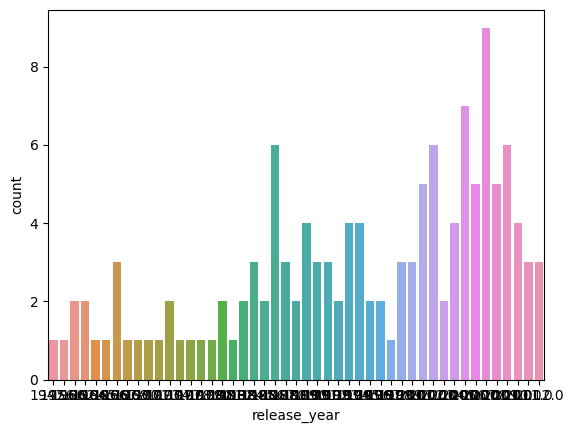

In [87]:
time_travel_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(time_travel_keywords), case=False)
print(f'Total summaries related : {time_travel_mask.sum()}')
sns.countplot(df_fictional_summaries_all[time_travel_mask], x = 'release_year')

Total summaries related : 503


<Axes: xlabel='release_year', ylabel='count'>

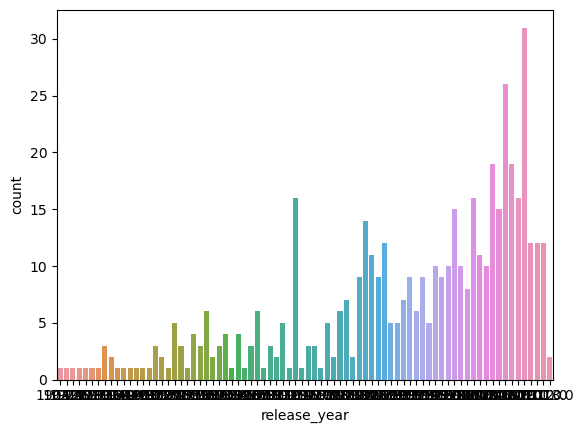

In [86]:
government_keywords = [
    "government",
    "society",
    "politics",
    "regime",
    "council"
]
governement_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(government_keywords), case=False)
print(f'Total summaries related : {governement_mask.sum()}')
sns.countplot(df_fictional_summaries_all[governement_mask], x = 'release_year')

Total summaries related : 1050


<Axes: xlabel='release_year', ylabel='count'>

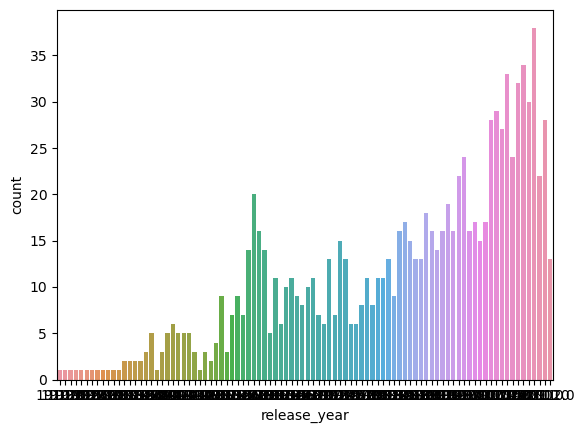

In [85]:
scientist_keywords = [
    "scientist",
    "science",
    "researcher",
    "experiment",
    "experimentation",
    "laboratory"
]

science_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(scientist_keywords), case=False)
print(f'Total summaries related : {science_mask.sum()}')
sns.countplot(df_fictional_summaries_all[science_mask], x = 'release_year')

Total summaries related : 635


<Axes: xlabel='release_year', ylabel='count'>

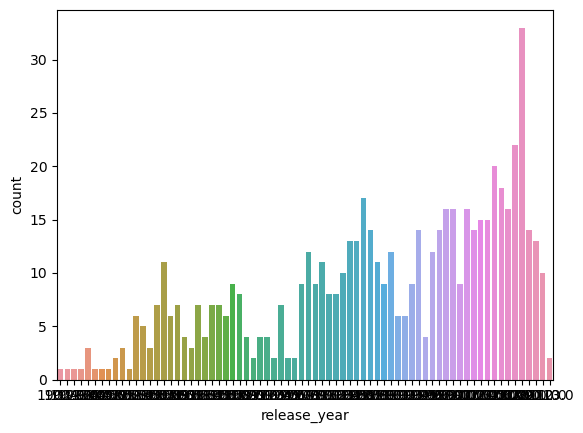

In [80]:
space_keywords = [
    "space",
    "spaceship"
]
space_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(space_keywords), case=False)
print(f'Total summaries related : {space_mask.sum()}')
sns.countplot(df_fictional_summaries_all[space_mask], x = 'release_year')

Total summaries related : 547


<Axes: xlabel='release_year', ylabel='count'>

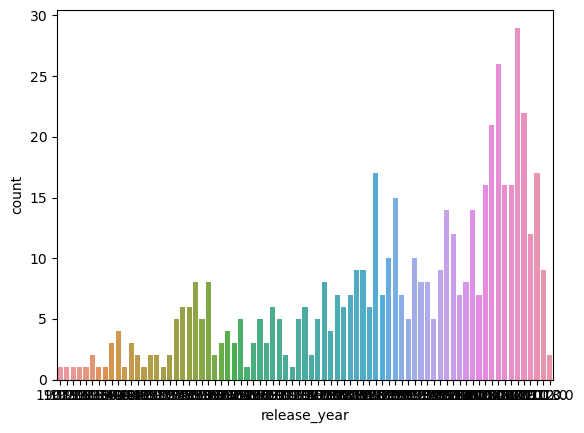

In [82]:
creature_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains(" creature ", case=False)
print(f'Total summaries related : {creature_mask.sum()}')
sns.countplot(df_fictional_summaries_all[creature_mask], x='release_year')

Total summaries related : 695


<Axes: xlabel='release_year', ylabel='count'>

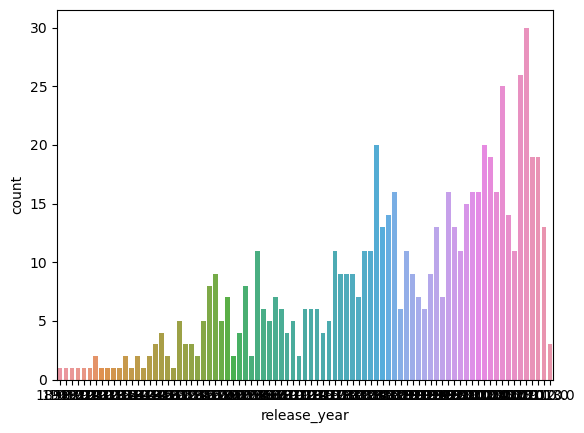

In [81]:
planet_keywords = ["planet", "moon", "mars", "saturn", "venus"]

planet_movies = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(planet_keywords), case=False)
print(f'Total summaries related : {planet_movies.sum()}')
sns.countplot(df_fictional_summaries_all[planet_movies], x='release_year')

695


<Axes: xlabel='release_year', ylabel='count'>

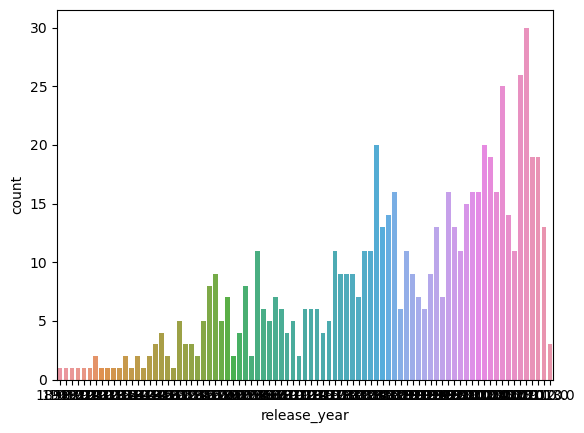

In [207]:
spaceship = ["spaceship", 'satellite', 'space crew', "cosmonaut"]
spaceship_movies = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(planet_keywords), case=False)
print(spaceship_movies.sum())
sns.countplot(df_fictional_summaries_all[spaceship_movies], x='release_year')

137


<Axes: xlabel='release_year', ylabel='count'>

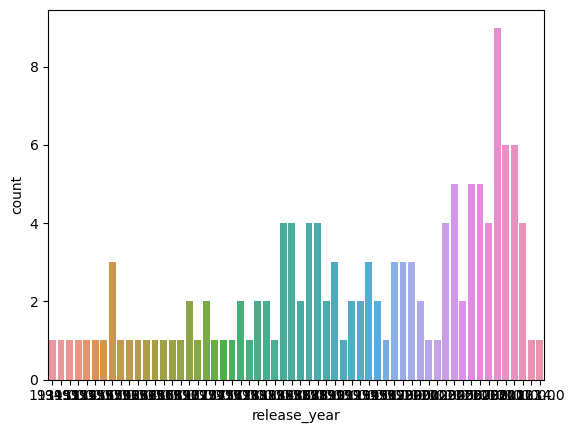

In [102]:


# You can print or use this list as needed
apocalypse_movies = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(apocalypse_related), case=False)
print(apocalypse_movies.sum())
sns.countplot(df_fictional_summaries_all[apocalypse_movies], x='release_year')

# Sentiment analysis of all movie summaries and initial assessment

In [ ]:
from scipy import stats
from nltk import sent_tokenize
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe("spacytextblob")

def sentiment_analysis(text):
    sentiment = nlp(text)._.polarity
    return sentiment

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [ ]:
df_movies_summaries['sentence_sentiment_score'] = df_movies_summaries['movie_summary'].apply(sentiment_analysis)

In [ ]:
df_sentiment_score_backup = df_movies_summaries

In [ ]:
df_movies_summaries['n_sentences'] = df_movies_summaries['movie_summary'].apply(count_sentences)

Do we need to consider the length of the summaries?

In [ ]:
sentiment_score_per_length = []
n_summaries_per_length = []
for i in range(1,100):
    temp = df_movies_summaries[df_movies_summaries['n_sentences'] == i]
    sentiment_score_per_length.append(np.mean(temp['sentence_sentiment_score']))
    n_summaries_per_length.append(len(temp))

(0.0, 0.1)

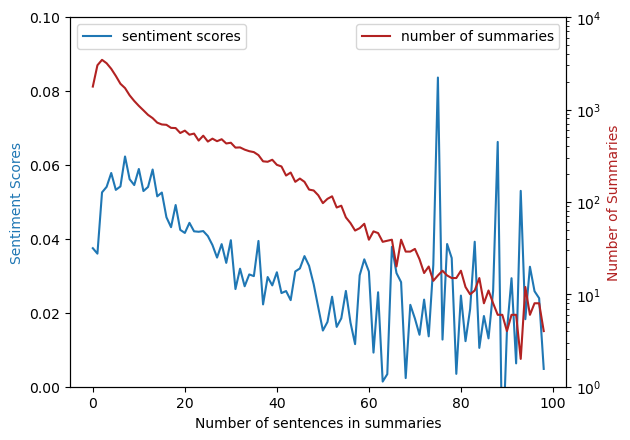

In [ ]:
fig,ax = plt.subplots()
ax.plot(sentiment_score_per_length, label='sentiment scores')
ax2 = ax.twinx()
ax2.plot(n_summaries_per_length, label='number of summaries', color='firebrick')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel('Number of sentences in summaries')
ax.set_ylabel('Sentiment Scores', color='#1f77b4')
ax2.set_ylabel('Number of Summaries', color='firebrick')
ax2.set_yscale('log')
ax2.set_ylim(1,10000)
ax.set_ylim(0,0.1)

What are the sentiment scores of short (3-20 sentences) and long (30-50 sentences) movie summaries?

In [ ]:
short_summaries = df_movies_summaries[(df_movies_summaries['n_sentences'] >= 3) &
                                      (df_movies_summaries['n_sentences'] <= 20)]
long_summaries = df_movies_summaries[(df_movies_summaries['n_sentences'] >= 30) &
                                            (df_movies_summaries['n_sentences'] <= 50)]
print('short: ', np.mean(short_summaries['sentence_sentiment_score']))
print('long: ', np.mean(long_summaries['sentence_sentiment_score']))
print('all: ', np.mean(df_movies_summaries['sentence_sentiment_score']))

short:  0.05423304293552305
long:  0.030298011615262035
all:  0.046300941285147654


In [ ]:
sentiment_t_value, sentiment_p_value = stats.ttest_ind(short_summaries['sentence_sentiment_score'],
                                                        long_summaries['sentence_sentiment_score'],
                                                          nan_policy='omit')

print('p-value: ', sentiment_p_value)
print('t-value:', sentiment_t_value)

p-value:  6.199533574735384e-37
t-value: 12.712775308697783


There is also a very big variance for the sentiment scores!

Text(0.5, 1.25, 'Sentiment score means and distributions for diffferent summary lengths')

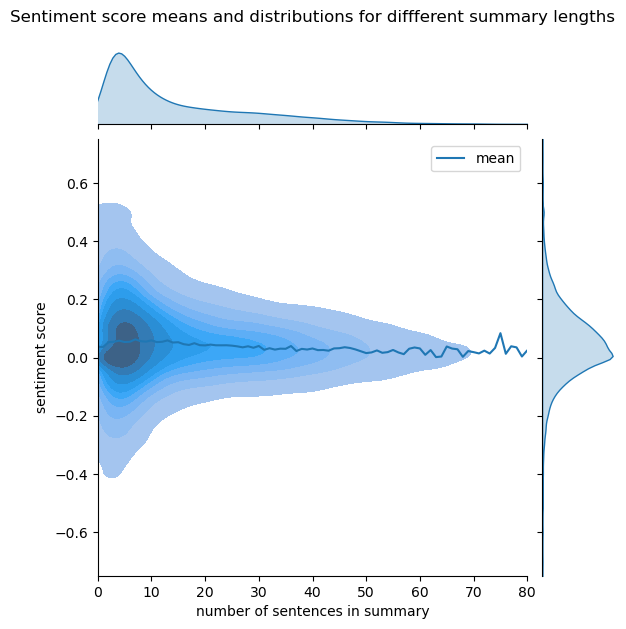

In [ ]:
contour_plot_df = df_movies_summaries[df_movies_summaries['n_sentences'] <= 100]

sns.jointplot(kind='kde', data=contour_plot_df, x="n_sentences", y="sentence_sentiment_score",fill=True)
plt.plot(sentiment_score_per_length, label='mean')
plt.legend()
plt.xlim(0,80)
plt.ylim(-0.75,0.75)
plt.xlabel('number of sentences in summary')
plt.ylabel('sentiment score')
plt.title('Sentiment score means and distributions for diffferent summary lengths', y=1.25)

What happens if we look at specific periods in time? Do old movies have a high sentiment score because they more likely to have short summaries?

In [ ]:
time_periods = [0, 1950, 1960, 1970, 1980, 1990, 2000, 2005, 2010, 2023]
time_period_labels = ['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', ' after 2010s']

time_periods_df_movies_summaries = []

for i in range(len(time_periods)):
    if i > 0:
        temp = df_movies_summaries[(df_movies_summaries.release_year > time_periods[i-1])
                                    & (df_movies_summaries.release_year <= time_periods[i])]
        time_periods_df_movies_summaries.append(temp)

How is the distriution of summary length in relationship with the release year of the movie?

total number of movie summaries considered:  39585


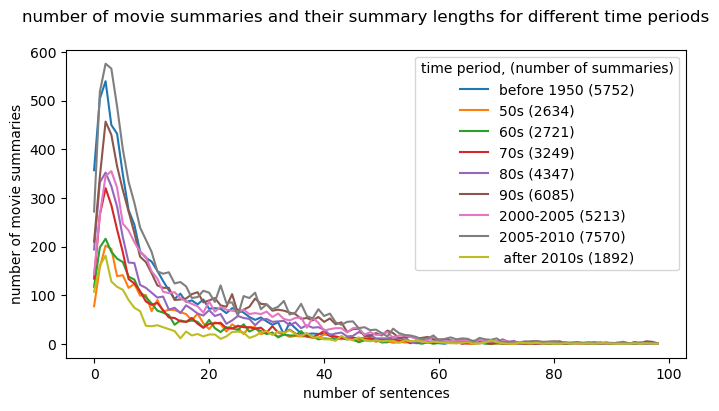

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

sum = 0

for i, df in enumerate(time_periods_df_movies_summaries):
    data = []
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j]))
    plt.plot(data, label=str(time_period_labels[i]) + ' (' + str(np.sum(data))+')')
    sum += np.sum(data)
plt.legend(title='time period, (number of summaries)', fontsize=10)
ax.set_ylabel('number of movie summaries')
ax.set_xlabel('number of sentences')
plt.suptitle('number of movie summaries and their summary lengths for different time periods')

print('total number of movie summaries considered: ', 
      np.sum([len(x) for x in time_periods_df_movies_summaries]))

what about the proportions?

Text(0.5, 1.0, 'proportion of movie summaries and their summary lengths for different time periods')

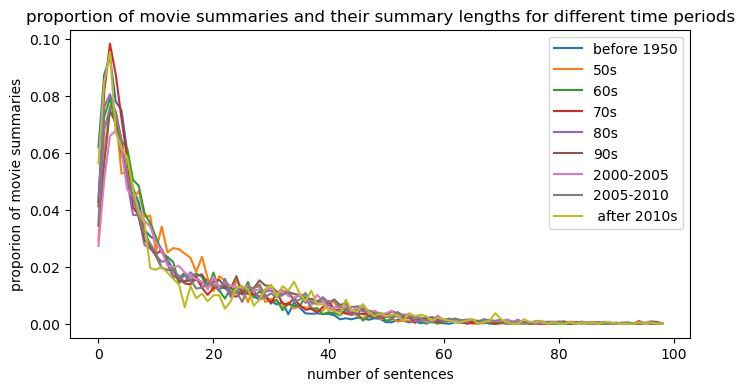

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(time_periods_df_movies_summaries):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    plt.plot(data, label=time_period_labels[i])
plt.legend()
ax.set_ylabel('proporion of movie summaries')
ax.set_xlabel('number of sentences')
ax.set_title('proportion of movie summaries and their summary lengths for different time periods')

Since the distribution of summary lengths is very similar for all periods of time, there should be no issues.

#Sentiment analysis: Adjustment for summary length and 

# sentiment of fictional movies

In [ ]:
df_movies_summaries = pd.merge(df_movies_summaries, df_fictional_summaries_all[['Wikipedia_movie_ID']],
                                on='Wikipedia_movie_ID', how='left', indicator=True)

df_movies_summaries['fiction'] = df_movies_summaries['_merge'] == 'both'
df_movies_summaries = df_movies_summaries.drop(['_merge'], axis=1)
df_movies_summaries['fiction'] = df_movies_summaries['fiction'].fillna(False)

df_movies_summaries_fiction = df_movies_summaries[df_movies_summaries['fiction']==True].reset_index()
df_movies_summaries_nonfiction = df_movies_summaries[df_movies_summaries['fiction']==False].reset_index()

# add the sentiment scores to df_fictional_summaries_all
df_fictional_summaries_all = pd.merge(df_fictional_summaries_all, 
                                      df_movies_summaries[['sentence_sentiment_score', 'Wikipedia_movie_ID']],
                                        on='Wikipedia_movie_ID', how='left')

first we want to make sure that the distribtion of summary lengths among the fictional movies is not unusual

Text(0.5, 0.98, 'number of movie summaries and their summary lengths for fiction/non-fiction')

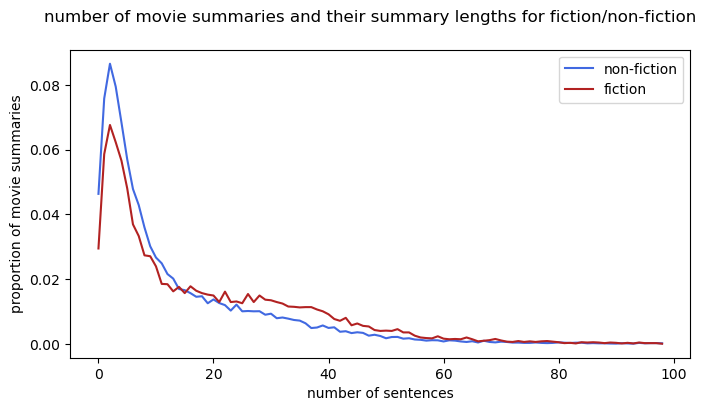

In [ ]:
dfs = [df_movies_summaries[df_movies_summaries['fiction']==False],
       df_movies_summaries[df_movies_summaries['fiction']==True]]

fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(dfs):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    if i == 0:
        label = 'non-fiction'
        color='royalblue'
    else:
        label = 'fiction'
        color='firebrick'
    plt.plot(data, label=label, color=color)
plt.legend(fontsize=10)
ax.set_ylabel('proportion of movie summaries')
ax.set_xlabel('number of sentences')
plt.suptitle('number of movie summaries and their summary lengths for fiction/non-fiction')

sentiment of fictional movies for different periods of time

In [ ]:
df_fiction_by_period = []
for i in range(len(time_periods)):
    if i > 0:
        temp = df_movies_summaries_fiction[(df_movies_summaries_fiction.release_year > time_periods[i-1])
                                    & (df_movies_summaries_fiction.release_year <= time_periods[i])]
        df_fiction_by_period.append(temp)

In [ ]:
df_non_fiction_by_period = []
for i in range(len(time_periods)):
    if i > 0:
        temp = df_movies_summaries_nonfiction[(df_movies_summaries_nonfiction.release_year > time_periods[i-1])
                                    & (df_movies_summaries_nonfiction.release_year <= time_periods[i])]
        df_non_fiction_by_period.append(temp)

Text(0.5, 1.0, 'Movie summaries by summary lengths for different time periods')

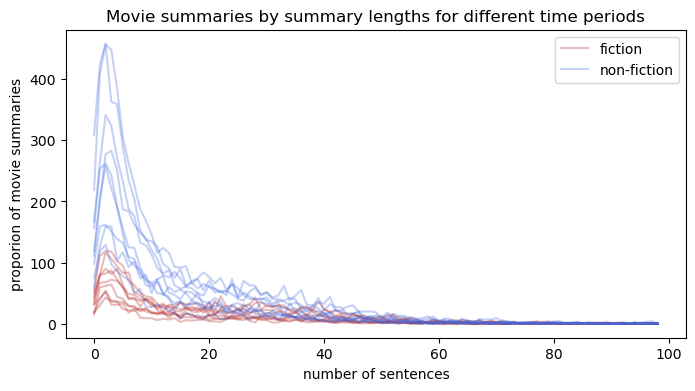

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(df_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j]))
    if i == 1:
        plt.plot(data, label='fiction', color='firebrick', alpha=0.3)
    else:
        plt.plot(data, color='firebrick', alpha=0.3)

for i, df in enumerate(df_non_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j]))
    if i == 0:
        plt.plot(data, label='non-fiction', color='royalblue', alpha=0.3)
    else:
        plt.plot(data, color='royalblue', alpha=0.3)
plt.legend()
ax.set_ylabel('proporion of movie summaries')
ax.set_xlabel('number of sentences')
ax.set_title('Movie summaries by summary lengths for different time periods')

Text(0.5, 1.0, 'Movie summary proportion by summary lengths for different time periods')

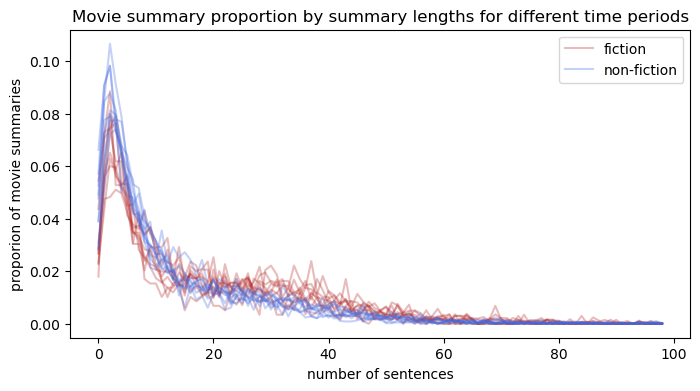

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(df_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    if i == 1:
        plt.plot(data, label='fiction', color='firebrick', alpha=0.3)
    else:
        plt.plot(data, color='firebrick', alpha=0.3)

for i, df in enumerate(df_non_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    if i == 0:
        plt.plot(data, label='non-fiction', color='royalblue', alpha=0.3)
    else:
        plt.plot(data, color='royalblue', alpha=0.3)
plt.legend()
ax.set_ylabel('proporion of movie summaries')
ax.set_xlabel('number of sentences')
ax.set_title('Movie summary proportion by summary lengths for different time periods')

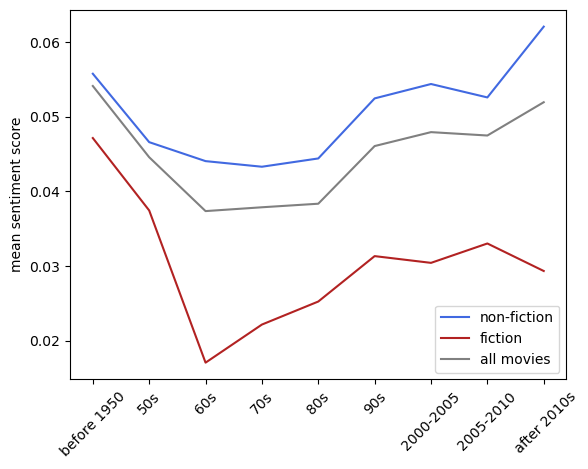

In [ ]:
plt.plot(time_period_labels, [np.mean(df.sentence_sentiment_score) for df in df_non_fiction_by_period],
         label='non-fiction', color='royalblue')
plt.plot(time_period_labels, [np.mean(df.sentence_sentiment_score) for df in df_fiction_by_period], 
         label = 'fiction', color = 'firebrick')
plt.plot(time_period_labels, [np.mean(df.sentence_sentiment_score) for df in time_periods_df_movies_summaries], 
         label = 'all movies', color = 'grey')
time_periods_df_movies_summaries
plt.xticks(rotation=45)
plt.ylabel('mean sentiment score')
plt.legend()

do weighted averages of the summary lengths change anything?

In [ ]:
summary_lengths = range(1,70)

group_sentiments_len_sentence = pd.DataFrame(index=range(len(fiction_by_period)), 
                                             columns=summary_lengths)
weights_by_sentences =[]

uncounted_summaries = 0

for summary_length in summary_lengths:
    mean_sentiments_current_length = []
    n_movies_current_length = []
    
    # find out how many movies there are for current summary length
    for movie_group in fiction_by_period:
        temp = movie_group[movie_group['n_sentences'] == summary_length]
        n_movies_current_length.append(len(temp))
        mean_sentiments_current_length.append(np.mean(temp.sentiment_score))
    weights_by_sentences.append(min(n_movies_current_length))
    if min(n_movies_current_length) == 0:
        uncounted_summaries += sum(n_movies_current_length)
    group_sentiments_len_sentence[summary_length] = mean_sentiments_current_length

group_sentiments_len_sentence = group_sentiments_len_sentence.T

print('weights: ', weights_by_sentences)
print('fraction of uncounted summairies: ', uncounted_summaries/len(fantasy_scifi_movies))
group_sentiments_len_sentence